# Numerical experiments

In [58]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import mosek
from mosek.fusion import *

In [4]:
from symbulate import *
%matplotlib inline

In [5]:
import scipy
from scipy.stats import lognorm

In [6]:
from numpy import array, dot

In [7]:
import itertools

In [8]:
%run Embeddings.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from line_profiler import LineProfiler

## Deliverable methods (used for computing the different objective functions)

### Low-rank

In [10]:
def low_rank_evaluate_h(x, y, z_j_s, h, Q, sig):
    z = (x,y)
    return np.dot(np.dot(Kernel_Vector_Double(z_j_s, z, sig),Q),h) 

In [11]:
def low_rank_radon_nykodym_derivative(x, y, z_j_s, h, Q, sig):
    return 1 + low_rank_evaluate_h(x, y, z_j_s, h, Q, sig)

### Greedy

In [12]:
def greedy_evaluate_h(x, y, y_j_s, h_s, Q_Y, sig_y):
    h_i = h_s[int(x),:]
    h_evaluated = np.dot(np.dot(Kernel_Vector_Single(y_j_s, y, sig_y), Q_new_Y),h_i)
    return h_evaluated

In [13]:
def greedy_radon_nykodym_derivative(x, y, y_j_s, h_s, Q_Y, sig_y):
    return 1 + greedy_evaluate_h(x, y, y_j_s, h_s, Q_Y, sig_y)

## Conditional probabilities

In [14]:
def true_conditional_probability_normal_multivariate(x,y):
    return norm.cdf(y, rho * x, (1 - np.power(rho,2)) * (1/25))

In [15]:
def true_conditional_probability_binomial_gaussian(x,y):
    return norm.cdf(y, 0, 1)

In [16]:
def true_conditional_probability_poisson_lognormal(x,y):
    return lognorm.cdf(y,1, 0, 1)

In [17]:
def lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, y_sample, Q_new, h, sig):
    ## Compute P(Y<=y_sample|X=x_val)
    n = np.shape(y_sorted)[0]
    training_y = y_sorted[y_sorted < y_sample]
    if(np.shape(training_y)[0] == 0):
        return 0
    matrix = list(map(lambda y_val: Kernel_Vector_Double(z_new,(x_val,y_val),sig) , training_y))
    sd = np.dot(np.dot(matrix,Q_new),h)
    sl = 1 + sd
    return (1/n) * np.sum(sl)

In [18]:
def greedy_embedding_conditional_probability(x_val, y_sample, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y):
    ## Compute P(Y<=y_sample|X=x_val)
    n = np.shape(y_sorted)[0]
    h_i = h_s[np.where(unique == x_val)[0],:]
    training_y = y_sorted[y_sorted < y_sample]
    if(np.shape(training_y)[0] == 0):
        return 0
    matrix = list(map(lambda y_val: Kernel_Vector_Single(y_j_s,y_val,sig_y), training_y))
    sd = np.dot(h_i,np.dot(matrix,Q_new_Y).T)
    sl = 1 + sd
    return (1/n) * np.sum(sl)

## Validation (Tuning hyperparameters)

### Objective functions

In [19]:
def lowrank_embedding_validation_objective(h, sig):
    mat = t(y_va) - lowrank_embedding_t_expectation_alternative(x_va, h_constrained, sig)
    mat_2 = np.power(mat,2)
    return np.sum(mat_2)

In [20]:
def traditional_embedding_validation_objective(M_traditional, x_tr, sig_x):
    result = 0.0
    for x_val_sample, y_val_sample in normal_va:
        result += np.power(np.linalg.norm(t(y_val_sample) - traditional_embedding_t_expectation(M_traditional, x_tr, x_val_sample, sig_x),2),2)
    return result

### Search domain

In [20]:
rf_sigma_x = [1.0e-3, 1.0e-2, 0.1]
rf_sigma_y = [1.0e-3, 1.0e-2, 0.1]
rf_lambda_ = [0.001, 0.1, 1, 5, 10]
rf_epsilon = [1.0e-3, 1.0e-2, 0.1]

In [21]:
## Search domains for the hyperparameters in traditionnal embedding approach

search_domain_hyperparameters_lowrank_embedding = list(itertools.product(rf_sigma_x, rf_sigma_y,rf_epsilon))
search_domain_hyperparameters_traditional_embedding = list(itertools.product(rf_lambda_,rf_sigma_x))

### Minimizing the objective function (grid search)

In [22]:
objectives_constrained = []
objectives_unconstrained = []
for combination in search_domain_hyperparameters_lowrank_embedding:
    
    # train the model with training data
    h_constrained, z_new, Q_new, h_unconstrained = low_rank_embedding(y_tr, x_tr, [combination[0], combination[1]], combination[2], 0.0)
    
    # score the model with validation data
    objectives_constrained.append([lowrank_embedding_validation_objective(h_constrained, sig)])
    objectives_unconstrained.append([lowrank_embedding_validation_objective(h_unconstrained, sig)])

min_value_constrained = min(objectives_constrained)
min_index_constrained = objectives_constrained.index(min_value_constrained)
hyperparameters_constrained = search_domain_hyperparameters_lowrank_embedding[min_index_constrained]


min_value_unconstrained = min(objectives_unconstrained)
min_index_unconstrained = objectives_unconstrained.index(min_value_unconstrained)
hyperparameters_unconstrained = search_domain_hyperparameters_lowrank_embedding[min_index_unconstrained]
hyperparameters_constrained

NameError: name 'y_tr' is not defined

In [ ]:
## Same procedure as the above cell but for the traditional embedding approach
objectives_traditional = []
for combination in search_domain_hyperparameters_traditional_embedding:    
    # train the model with training data
    M_traditional = traditional_embedding(x_tr, combination[0], combination[1])
    
    # score the model with validation data
    objectives_traditional.append([traditional_embedding_validation_objective(M_traditional, combination[1])])

min_value_traditional = min(objectives_traditional)
min_index_traditional = objectives_traditional.index(min_value_traditional)
hyperparameters_traditional = search_domain_hyperparameters_traditional_embedding[min_index_traditional]
hyperparameters_traditional

## Testing

### Methods used in testing (t-Expectations for Condtional Probabilities)

In [21]:
def u(y):
    return np.array([y <= 0.3, y <= 0.6, y <= 0.9])

In [22]:
def t(y):
    return np.array([y <= -0.3, y <= -0.2, y <= -0.1])

In [23]:
def normal_multivariate_t_expectation(x):
     return np.array([true_conditional_probability_normal_multivariate(x, -0.3), true_conditional_probability_normal_multivariate(x, -0.2), true_conditional_probability_normal_multivariate(x, -0.1)])

In [24]:
def binomial_gaussian_t_expectation(x): 
     return np.array([true_conditional_probability_binomial_gaussian(x, -0.3),true_conditional_probability_binomial_gaussian(x, -0.2),true_conditional_probability_binomial_gaussian(x, -0.1)])

In [25]:
def poisson_lognormal_u_expectation(x): 
     return np.array([true_conditional_probability_poisson_lognormal(x, 0.3), true_conditional_probability_poisson_lognormal(x, 0.6), true_conditional_probability_poisson_lognormal(x, 0.9)])

In [26]:
poisson_lognormal_u_expectation(0.3)

array([0.11430005, 0.30473658, 0.45804487])

In [27]:
def lowrank_embedding_t_expectation(x_val, y_sorted, z_new, Q_new, h, sig):
        return np.array([lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, -0.3, Q_new, h, sig), lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, -0.2, Q_new, h, sig), lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, -0.1, Q_new, h, sig)])

In [28]:
def traditional_embedding_t_expectation(M_traditional, x_tr, y_tr, x_val, sig_x):
    vector =  np.dot(M_traditional,Kernel_Vector_Single(x_tr, x_val, sig_x))
    return np.dot(t(y_tr),vector)

In [29]:
def greedy_embedding_t_expectation(x_val, y_sorted, y_j_s, unique, Q_new_Y, h_s, sig_y):
        return np.array([greedy_embedding_conditional_probability(x_val, -0.3, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y), greedy_embedding_conditional_probability(x_val, -0.2, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y), greedy_embedding_conditional_probability(x_val, -0.1, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y)])

In [30]:
def lowrank_embedding_u_expectation(x_val, y_sorted, z_new, Q_new, h, sig):
        return np.array([lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, 0.3, Q_new, h, sig), lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, 0.6, Q_new, h, sig), lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, 0.9, Q_new, h, sig)])

In [31]:
def traditional_embedding_u_expectation(M_traditional, x_tr, y_tr, x_val, sig_x):
    vector =  np.dot(M_traditional,Kernel_Vector_Single(x_tr, x_val, sig_x))
    return np.dot(u(y_tr),vector)

In [32]:
def greedy_embedding_u_expectation(x_val, y_sorted, y_j_s, unique, Q_new_Y, h_s, sig_y):
        return np.array([greedy_embedding_conditional_probability(x_val, 0.3, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y), greedy_embedding_conditional_probability(x_val, 0.6, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y), greedy_embedding_conditional_probability(x_val, 0.9, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y)])

### Methods used in testing (for classification)

In [33]:
def classifier_1(y):
    return np.array([y <= 0.0])

In [34]:
def classifier_2(y):
    return np.array([y <= 1.0])

In [35]:
def lowrank_embedding_classification_1_probability(x_val, y_sorted, z_new, Q_new, h, sig):
    return lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, 0.0, Q_new, h, sig)

In [36]:
def lowrank_embedding_classification_2_probability(x_val, y_sorted, z_new, Q_new, h, sig):
    return lowrank_embedding_conditional_probability(x_val, y_sorted, z_new, 1.0, Q_new, h, sig)

In [37]:
def traditional_embedding_classification_1_probability(M_traditional, x_tr, y_tr, x_val, sig_x):
    vector =  np.dot(M_traditional,Kernel_Vector_Single(x_tr, x_val, sig_x))
    return np.dot(classifier_1(y_tr),vector)

In [38]:
def traditional_embedding_classification_2_probability(M_traditional, x_tr, y_tr, x_val, sig_x):
    vector =  np.dot(M_traditional,Kernel_Vector_Single(x_tr, x_val, sig_x))
    return np.dot(classifier_2(y_tr),vector)

In [39]:
def greedy_embedding_classification_1_probability(x_val, y_sorted, y_j_s, unique, Q_new_Y, h_s, sig_y):
    return greedy_embedding_conditional_probability(x_val, 0.0, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y)

In [40]:
def greedy_embedding_classification_2_probability(x_val, y_sorted, y_j_s, unique, Q_new_Y, h_s, sig_y):
    return greedy_embedding_conditional_probability(x_val, 1.0, y_j_s, y_sorted, unique, Q_new_Y, h_s, sig_y)

### Methods 

### Test functions

#### Prediction

##### Normal multivariate test functions

In [43]:
def lowrank_embedding_prediction_test_objective_normal_multivariate(h, y_sorted, z_new, Q_new, z_te, sig):
    result = 0.0
    for x_te_sample, y_te_sample in z_te:
        result += np.power(np.linalg.norm(normal_multivariate_t_expectation(x_te_sample) - lowrank_embedding_t_expectation(x_te_sample, y_sorted, z_new, Q_new, h, sig),2),2)
    return result

In [44]:
def traditional_embedding_prediction_test_objective_normal_multivariate(M_traditional, x_tr, y_tr, z_te, sig):
    result = 0.0
    for x_te_sample, y_te_sample in z_te:
        result += np.power(np.linalg.norm(normal_multivariate_t_expectation(x_te_sample) - traditional_embedding_t_expectation(M_traditional, x_tr, y_tr, x_te_sample, sig),2),2)
    return result

##### Binomial-Gaussian test functions

In [ ]:
def lowrank_embedding_prediction_test_objective_binomial_gaussian(h, y_sorted, z_new, Q_new, z_te, sig):
    result = 0.0
    for x_te_sample, y_te_sample in z_te:
        result += np.power(np.linalg.norm(binomial_gaussian_t_expectation(x_te_sample) - lowrank_embedding_t_expectation(x_te_sample, y_sorted, z_new, Q_new, h, sig),2),2)
    return result

In [ ]:
def traditional_embedding_prediction_test_objective_binomial_gaussian(M_traditional, x_tr, y_tr, z_te, sig):
    result = 0.0
    for x_te_sample, y_te_sample in z_te:
        result += np.power(np.linalg.norm(binomial_gaussian_t_expectation(x_te_sample) - traditional_embedding_t_expectation(M_traditional, x_tr, y_tr, x_te_sample, sig),2),2)
    return result

In [ ]:
def greedy_embedding_prediction_test_objective_binomial_gaussian(h_s, y_sorted, y_j_s, unique, Q_new_Y, z_te, sig_y):
    result = 0.0
    for x_te_sample, y_te_sample in z_te:
        result += np.power(np.linalg.norm(binomial_gaussian_t_expectation(x_te_sample) - greedy_embedding_t_expectation(x_te_sample, y_sorted, y_j_s, unique, Q_new_Y, h_s, sig_y),2),2)
    return result

##### Poisson-LogNormal test functions

In [47]:
def lowrank_embedding_prediction_test_objective_poisson_lognormal(h, y_sorted, z_new, Q_new, z_te, sig):
    result = 0.0
    for x_te_sample, y_te_sample in z_te:
        result += np.power(np.linalg.norm(poisson_lognormal_u_expectation(x_te_sample) - lowrank_embedding_u_expectation(x_te_sample, y_sorted, z_new, Q_new, h, sig),2),2)
    return result

In [48]:
def traditional_embedding_prediction_test_objective_poisson_lognormal(M_traditional, x_tr, y_tr, z_te, sig):
    result = 0.0
    for x_te_sample, y_te_sample in z_te:
        result += np.power(np.linalg.norm(poisson_lognormal_u_expectation(x_te_sample) - traditional_embedding_u_expectation(M_traditional, x_tr, y_tr, x_te_sample, sig),2),2)
    return result    

In [49]:
def greedy_embedding_prediction_test_objective_poisson_lognormal(h_s, y_sorted, y_j_s, unique, Q_new_Y, z_te, sig_y):
    result = 0.0
    for x_te_sample, y_te_sample in z_te:
        result += np.power(np.linalg.norm(poisson_lognormal_u_expectation(x_te_sample) - greedy_embedding_u_expectation(x_te_sample, y_sorted, y_j_s, unique, Q_new_Y, h_s, sig_y),2),2)
    return result

#### Classification

In [41]:
def lowrank_embedding_classification_1_test_objective(h, y_sorted, z_new, Q_new, z_te, sig):
    result = 0.0
    N = np.shape(z_te)[0]
    for x_te_sample, y_te_sample in z_te:
        p_i = lowrank_embedding_classification_1_probability(x_te_sample, y_sorted, z_new, Q_new, h, sig)
        print(p_i)
        r = y_te_sample <= 0
        print(r)
        result += (-  ( r * np.log(p_i)  + (1 - r) * np.log(1 - p_i)))
    return (1/N) * result 

In [42]:
def lowrank_embedding_classification_2_test_objective(h, y_sorted, z_new, Q_new, z_te, sig):
    result = 0.0
    N = np.shape(z_te)[0]
    for x_te_sample, y_te_sample in z_te:
        p_i = lowrank_embedding_classification_2_probability(x_te_sample, y_sorted, z_new, Q_new, h, sig)
        print(p_i)
        r = y_te_sample <= 0
        print(r)
        result += (-  ( r * np.log(p_i)  + (1 - r) * np.log(1 - p_i)))
    return (1/N) * result 

In [43]:
def traditional_embedding_classification_1_test_objective(M_traditional, x_tr, y_tr, z_te, sig_x):
    result = 0.0
    N = np.shape(z_te)[0]
    for x_te_sample, y_te_sample in z_te:
        p_i = traditional_embedding_classification_1_probability(M_traditional, x_tr, y_tr, x_te_sample, sig_x)
        r = y_te_sample <= 0
        result += (-  ( r * np.log(p_i)  + (1 - r) * np.log(1 - p_i)))
    return (1/N) * result 

In [44]:
def traditional_embedding_classification_2_test_objective(M_traditional, x_tr, y_tr, z_te, sig_x):
    result = 0.0
    N = np.shape(z_te)[0]
    for x_te_sample, y_te_sample in z_te:
        p_i = traditional_embedding_classification_2_probability(M_traditional, x_tr, y_tr, x_te_sample, sig_x)
        r = y_te_sample <= 0
        result += (-  ( r * np.log(p_i)  + (1 - r) * np.log(1 - p_i)))
    return (1/N) * result 

In [45]:
def greedy_embedding_classification_1_test_objective(h, y_sorted, z_new, unique, Q_new, z_te, sig):
    result = 0.0
    N = np.shape(z_te)[0]
    for x_te_sample, y_te_sample in z_te:
        p_i = greedy_embedding_classification_1_probability(x_te_sample, y_sorted, z_new, unique, Q_new, h, sig)
        r = y_te_sample <= 0
        result += (-  ( r * np.log(p_i)  + (1 - r) * np.log(1 - p_i)))
    return (1/N) * result 

In [46]:
def greedy_embedding_classification_2_test_objective(h, y_sorted, z_new, unique, Q_new, z_te, sig_y):
    result = 0.0
    N = np.shape(z_te)[0]
    for x_te_sample, y_te_sample in z_te:
        p_i = greedy_embedding_classification_2_probability(x_te_sample, y_sorted, z_new, unique, Q_new, h, sig_y)
        r = y_te_sample <= 0
        result += (-  ( r * np.log(p_i)  + (1 - r) * np.log(1 - p_i)))
    return (1/N) * result 

## Plots

In [54]:
def split_data(z, ratio_1, ratio_2, seed=1):
    """
    split the dataset based on the split ratio. If ratio_1 is 0.7, and ratio_2 is 0.2, 
    you will have 70% of your data set dedicated to training, 20% dedicated to validating 
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.
    
    Args:
        z: numpy array of shape (N,), N is the number of samples.
        ratio_1: scalar in [0,1]
        ratio_2: scalar in [0,1]
        seed: integer.
        
    Returns:
        z_tr: numpy array containing the train data.
        z_va: numpy array containing the validation data.
        z_te: numpy array containing the test data.
       
    >>> split_data(np.arange(13), 0.7, 0.2, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # set seed
    np.random.seed(seed)
    ### SOLUTION
    # generate random indices
    num_row = len(z)
    indices = np.random.permutation(num_row)
    index_1_split = int(np.floor(ratio_1 * num_row))
    index_2_split = int(np.floor((ratio_1 + ratio_2) * num_row))
    index_tr = indices[: index_1_split]
    index_va = indices[index_1_split: index_2_split]
    index_te = indices[index_2_split:]
    # create split
    z_tr = z[index_tr]
    z_va = z[index_va]
    z_te = z[index_te]
    
    return z_tr, z_va, z_te

### Normal multivariate case

#### Setup

In [ ]:
lambda_ = 1.0
epsilon = 0.01

mu, sigma = np.zeros(2) , np.eye(2)

sig_x, sig_y = np.random.uniform(1.0e-5,0.1,2)
sig = [sig_x, sig_y]

rho = 0.5

ratio_1 = 0.6
ratio_2 = 0.2

In [ ]:
def normal_multivariate_prediction_average_statistics(n, number_runs):
    statistics = []
    n_tr = ratio_1 * n
    N_tr = np.power(n_tr,2)
    rng = np.random.default_rng()
    for i in range(number_runs):
        print("Run #", i , "n = " , n)
        z = rng.multivariate_normal(mu, sigma, n)
        z_tr, z_va, z_te = split_data(z, ratio_1, ratio_2) 
        x_tr, y_tr = z_tr[:,0], z_tr[:,1]
        y_tr_sorted = np.array(sorted(y_tr))

        z_itertools = np.asarray(list(itertools.product(x_tr, y_tr)))

        h_constrained , z_j_s, Q = low_rank_embedding(z_tr, sig, epsilon, 0.0)
        M = traditional_embedding(x_tr, lambda_, sig_x) 
        lowrank_test = lowrank_embedding_prediction_test_objective_normal_multivariate(h_constrained, y_tr_sorted, z_j_s, Q, z_te, sig)
        traditional_test = traditional_embedding_prediction_test_objective_normal_multivariate(M, x_tr, y_tr, z_te, sig_x)
        print(lowrank_test, traditional_test)
        statistics.append([lowrank_test, traditional_test])
    
    statistics = np.array(statistics)
    return np.average(statistics, axis = 0)
        

In [ ]:
def plot_normal_multivariate_prediction_statistics(n_s, number_runs):
    a = []
    for n in n_s:
        a.append(normal_multivariate_prediction_average_statistics(n, number_runs))    
    a = np.array(a) 
    return a

#### Computations

In [ ]:
n_s = [50, 75, 100, 125, 150]
stats = plot_normal_multivariate_prediction_statistics(n_s, 10)

#### Plots

In [ ]:
plt.plot(n_s, stats[:,0], label = "Low-rank embedding")

plt.plot(n_s, stats[:,1], label = "Traditional embedding")

plt.xlabel('n')

plt.ylabel('cumulative test error')

plt.title('Low-rank vs Traditional')

plt.legend()
plt.savefig("Low-rankvsTraditionalCumulativeBivariate.png")
plt.show()

In [ ]:
stats[:,0] = stats[:,0]  / n_s

In [ ]:
stats[:,1] = stats[:,1] / n_s

In [ ]:
plt.plot(n_s, stats[:,0], label = "Low-rank embedding")

plt.plot(n_s, stats[:,1], label = "Traditional embedding")

plt.xlabel('n')

plt.ylabel('average test error')

plt.title('Low-rank vs Traditional')

plt.legend()
plt.savefig("Low-rankvsTraditionalAverageBivariate.png")
plt.show()

### Binomial Gaussian case

#### Setup

In [ ]:
lambda_ = 1.0
epsilon = 0.01

P = Binomial(2,0.5) * Normal(0,1)
X , Y = RV(P)

sig_x, sig_y = np.random.uniform(1.0e-5,0.1,2)
sig = [sig_x, sig_y]


ratio_1 = 0.6
ratio_2 = 0.2

# Prediction

In [ ]:
def binomial_gaussian_prediction_average_statistics(n, number_runs):
    statistics = []
    n_tr = ratio_1 * n
    N_tr = np.power(n_tr,2)
    rng = np.random.default_rng()
    simulation = np.asarray((X & Y).sim(n * number_runs))
    for i in range(number_runs):
        print("Run #", i , " n =", n)
        z = simulation[n * i : n * (i + 1),:]
        z_tr, z_va, z_te = split_data(z, ratio_1, ratio_2) 
        x_tr, y_tr = z_tr[:,0], z_tr[:,1]
        y_tr_sorted = np.array(sorted(y_tr))

        z_itertools = np.asarray(list(itertools.product(x_tr, y_tr)))

        h_constrained , z_j_s, Q = low_rank_embedding(z_tr, sig, epsilon, 0.0)
        M = traditional_embedding(x_tr, lambda_, sig_x)
        h_s, unique, y_j_s, Q_Y = greedy_embedding(z_tr, sig_y, epsilon, lambda_)
        
        lowrank_test = lowrank_embedding_prediction_test_objective_binomial_gaussian(h_constrained, y_tr_sorted, z_j_s, Q, z_te, sig)
        traditional_test = traditional_embedding_prediction_test_objective_binomial_gaussian(M, x_tr, y_tr, z_te, sig_x)
        greedy_test = greedy_embedding_prediction_test_objective_binomial_gaussian(h_s, y_tr_sorted, y_j_s, unique, Q_Y, z_te, sig_y)
        print(lowrank_test, traditional_test, greedy_test)
        statistics.append([lowrank_test, traditional_test, greedy_test])
    
    statistics = np.array(statistics)
    return np.average(statistics, axis = 0)
        

In [ ]:
def plot_binomial_gaussian_prediction_statistics(n_s, number_runs):
    a = []
    for n in n_s:
        a.append(binomial_gaussian_prediction_average_statistics(n, number_runs))    
    a = np.array(a) 
    return a

##### Computations

In [ ]:
n_s = [100, 125, 150, 175, 200]
stats = plot_binomial_gaussian_prediction_statistics(n_s, 10)

##### Plots

In [ ]:
plt.plot(n_s, stats[:,0], label = "Low-rank embedding")

plt.plot(n_s, stats[:,1], label = "Traditional embedding")

plt.plot(n_s, stats[:,2], label = "Greedy embedding")

plt.xlabel('n')

plt.ylabel('cumulative test error')

plt.title('Low-rank vs Traditional vs Greedy')

plt.legend()
plt.savefig("Low-rankvsTraditionalvsGreedyCumulativeBinomialGaussian.png")
plt.show()

In [ ]:
stats[:,0] = stats[:,0]  / n_s

stats[:,1] = stats[:,1]  / n_s

stats[:,2] = stats[:,2]  / n_s

plt.plot(n_s, stats[:,0], label = "Low-rank embedding")

plt.plot(n_s, stats[:,1], label = "Traditional embedding")

plt.plot(n_s, stats[:,2], label = "Greedy embedding")

plt.xlabel('n')

plt.ylabel('average test error')

plt.title('Low-rank vs Traditional vs Greedy')

plt.legend()
plt.savefig("Low-rankvsTraditionalvsGreedyAverageBinomial.png")
plt.show()

#### Classification

In [ ]:
def binomial_gaussian_classification_average_statistics(n, number_runs):
    statistics = []
    n_tr = ratio_1 * n
    N_tr = np.power(n_tr,2)
    rng = np.random.default_rng()
    simulation = np.asarray((X & Y).sim(n * number_runs))
    for i in range(number_runs):
        print("Run #", i , " n =", n)
        z = simulation[n * i : n * (i + 1),:]
        z_tr, z_va, z_te = split_data(z, ratio_1, ratio_2) 
        x_tr, y_tr = z_tr[:,0], z_tr[:,1]
        y_tr_sorted = np.array(sorted(y_tr))

        z_itertools = np.asarray(list(itertools.product(x_tr, y_tr)))

        h_constrained , z_j_s, Q = low_rank_embedding(z_tr, sig, epsilon, 0.0)
        M = traditional_embedding(x_tr, lambda_, sig_x)
        h_s, y_j_s, Q_Y = greedy_embedding(z_tr, sig_y, epsilon, lambda_)
        
        lowrank_test = lowrank_embedding_classification_1_test_objective(h_constrained, y_tr_sorted, z_j_s, Q, z_te, sig)
        traditional_test = traditional_embedding_classification_1_test_objective(M, x_tr, y_tr, z_te, sig_x)
        greedy_test = greedy_embedding_classification_1_test_objective(h_s, y_tr_sorted, y_j_s, unique, Q_Y, z_te, sig_y)
        print(lowrank_test, traditional_test, greedy_test)
        statistics.append([lowrank_test, traditional_test, greedy_test])
    
    statistics = np.array(statistics)
    return np.average(statistics, axis = 0)
        

In [ ]:
def plot_binomial_gaussian_classification_statistics(n_s, number_runs):
    a = []
    for n in n_s:
        a.append(binomial_gaussian_classification_average_statistics(n, number_runs))    
    a = np.array(a) 
    return a

##### Computations

In [ ]:
n_s = [50, 60, 70, 80, 90]
stats = plot_binomial_gaussian_classification_statistics(n_s, 5)

##### Plots

In [ ]:
plt.plot(n_s, stats[:,0], label = "Low-rank embedding")

plt.plot(n_s, stats[:,1], label = "Traditional embedding")

plt.plot(n_s, stats[:,2], label = "Greedy embedding")

plt.xlabel('n')

plt.ylabel('Mean Absolute Error')

plt.title('Low-rank vs Traditional vs Greedy')

plt.legend()
plt.savefig("Low-rankvsTraditionalvsGreedyClassificationBinomialGaussian.png")
plt.show()

### Poisson-LogNormal Distribution

#### Setup

In [50]:
lambda_ = 1.0
epsilon = 0.01

P = Poisson(lam = 3) * LogNormal(0,1)
X , Y = RV(P)

sig_x, sig_y = np.random.uniform(1.0e-5,0.1,2)
sig = [sig_x, sig_y]


ratio_1 = 0.6
ratio_2 = 0.2

#### Prediction

In [56]:
def poisson_lognormal_prediction_average_statistics(n, number_runs):
    statistics = []
    n_tr = ratio_1 * n
    N_tr = np.power(n_tr,2)
    rng = np.random.default_rng()
    simulation = np.asarray((X & Y).sim(n * number_runs))
    for i in range(number_runs):
        print("Run #", i , " n =", n)
        z = simulation[n * i : n * (i + 1),:]
        z_tr, z_va, z_te = split_data(z, ratio_1, ratio_2) 
        print(z_te)
        x_tr, y_tr = z_tr[:,0], z_tr[:,1]
        y_tr_sorted = np.array(sorted(y_tr))

        z_itertools = np.asarray(list(itertools.product(x_tr, y_tr)))

        h_constrained , z_j_s, Q = low_rank_embedding(z_tr, sig, epsilon, 0.0)
        M = traditional_embedding(x_tr, lambda_, sig_x)
        h_s, unique, y_j_s, Q_Y = greedy_embedding(z_tr, sig_y, epsilon, lambda_)
        
        lowrank_test = lowrank_embedding_prediction_test_objective_poisson_lognormal(h_constrained, y_tr_sorted, z_j_s, Q, z_te, sig)
        traditional_test = traditional_embedding_prediction_test_objective_poisson_lognormal(M, x_tr, y_tr, z_te, sig_x)
        greedy_test = greedy_embedding_prediction_test_objective_poisson_lognormal(h_s, y_tr_sorted, y_j_s, unique, Q_Y, z_te, sig_y)
        print(lowrank_test, traditional_test, greedy_test)
        statistics.append([lowrank_test, traditional_test, greedy_test])
    
    statistics = np.array(statistics)
    return np.average(statistics, axis = 0)
        

In [57]:
def plot_poisson_lognormal_prediction_statistics(n_s, number_runs):
    a = []
    for n in n_s:
        a.append(poisson_lognormal_prediction_average_statistics(n, number_runs))    
    a = np.array(a) 
    return a

##### Computation

In [58]:
n_s = [100, 125, 150, 175]
stats = plot_poisson_lognormal_prediction_statistics(n_s, 5)

Run # 0  n = 100
[[3.         1.79112451]
 [5.         2.50508404]
 [3.         0.59724735]
 [1.         0.21714615]
 [3.         5.21072892]
 [6.         1.63346125]
 [4.         0.87931612]
 [2.         0.79094172]
 [2.         0.30336835]
 [5.         0.35767233]
 [1.         0.84382207]
 [1.         0.34353663]
 [3.         0.98320523]
 [3.         2.20687287]
 [5.         0.78815955]
 [3.         3.17000936]
 [3.         2.06484712]
 [5.         2.44285545]
 [2.         1.76411476]
 [2.         0.88052762]]
Problem
  Name                   : cq01            
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 887             
  Cones                  : 1               
  Scalar variables       : 1768            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker termi

KeyboardInterrupt: 

In [ ]:
plt.plot(n_s, stats[:,0], label = "Low-rank embedding")

plt.plot(n_s, stats[:,1], label = "Traditional embedding")

plt.plot(n_s, stats[:,2], label = "Greedy embedding")

plt.xlabel('n')

plt.ylabel('Cumulative Test Error')

plt.title('Low-rank vs Traditional vs Greedy')

plt.legend()
plt.savefig("Low-rankvsTraditionalvsGreedyCumulativePoissonLognormal.png")
plt.show()

In [ ]:
stats[:,0] = stats[:,0] / n_s

stats[:,1] = stats[:,1] / n_s

stats[:,2] = stats[:,2] / n_s



In [ ]:
plt.plot(n_s, stats[:,0], label = "Low-rank embedding")

plt.plot(n_s, stats[:,1], label = "Traditional embedding")

plt.plot(n_s, stats[:,2], label = "Greedy embedding")

plt.xlabel('n')

plt.ylabel('Average Test Error')

plt.title('Low-rank vs Traditional vs Greedy')

plt.legend()
plt.savefig("Low-rankvsTraditionalvsGreedyAveragePoissonLognormal.png")
plt.show()

#### Classification

In [51]:
def poisson_lognormal_classification_average_statistics(n, number_runs):
    statistics = []
    n_tr = ratio_1 * n
    N_tr = np.power(n_tr,2)
    rng = np.random.default_rng()
    simulation = np.asarray((X & Y).sim(n * number_runs))
    for i in range(number_runs):
        print("Run #", i , " n =", n)
        z = simulation[n * i : n * (i + 1),:]
        z_tr, z_va, z_te = split_data(z, ratio_1, ratio_2) 
        x_tr, y_tr = z_tr[:,0], z_tr[:,1]
        y_tr_sorted = np.array(sorted(y_tr))

        z_itertools = np.asarray(list(itertools.product(x_tr, y_tr)))

        h_constrained , z_j_s, Q = low_rank_embedding(z_tr, sig, epsilon, 0.0)
        M = traditional_embedding(x_tr, lambda_, sig_x)
        h_s, unique, y_j_s, Q_Y = greedy_embedding(z_tr, sig_y, epsilon, lambda_)
        
        lowrank_test = lowrank_embedding_classification_2_test_objective(h_constrained, y_tr_sorted, z_j_s, Q, z_te, sig)
        traditional_test = traditional_embedding_classification_2_test_objective(M, x_tr, y_tr, z_te, sig_x)
        greedy_test = greedy_embedding_classification_2_test_objective(h_s, y_tr_sorted, y_j_s, unique, Q_Y, z_te, sig_y)
        print(lowrank_test, traditional_test, greedy_test)
        statistics.append([lowrank_test, traditional_test, greedy_test])
    
    statistics = np.array(statistics)
    return np.average(statistics, axis = 0)
        

In [52]:
def plot_poisson_lognormal_classification_statistics(n_s, number_runs):
    a = []
    for n in n_s:
        a.append(poisson_lognormal_classification_average_statistics(n, number_runs))    
    a = np.array(a) 
    return a

##### Computations

In [59]:
n_s = [50, 60, 70, 80]
stats = plot_poisson_lognormal_classification_statistics(n_s, 3)

Run # 0  n = 50
Problem
  Name                   : cq01            
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 355             
  Cones                  : 1               
  Scalar variables       : 704             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   : cq01            
  Objective sense        : min             
  Type                   : CONIC 

/tmp/ipykernel_44/2459576751.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  statistics = np.array(statistics)


  Scalar variables       : 732             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   : cq01            
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 369             
  Cones                  : 1               
  Scalar variables       : 732             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  -

/tmp/ipykernel_44/2524490338.py:7: RuntimeWarning: divide by zero encountered in log
  result += (-  ( r * np.log(p_i)  + (1 - r) * np.log(1 - p_i)))
/tmp/ipykernel_44/2524490338.py:7: RuntimeWarning: invalid value encountered in multiply
  result += (-  ( r * np.log(p_i)  + (1 - r) * np.log(1 - p_i)))


Problem
  Name                   : cq01            
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 635             
  Cones                  : 1               
  Scalar variables       : 1264            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   : cq01            
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

##### Plots

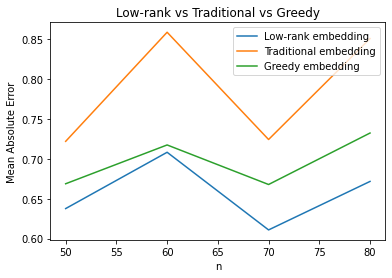

In [73]:
plt.plot(n_s, stats[:,0], label = "Low-rank embedding")

plt.plot(n_s, stats[:,1], label = "Traditional embedding")

plt.plot(n_s, stats[:,2], label = "Greedy embedding")

plt.xlabel('n')

plt.ylabel('Mean Absolute Error')

plt.title('Low-rank vs Traditional vs Greedy')

plt.legend()
plt.savefig("Low-rankvsTraditionalvsGreedyClassificationPoissonLognormal.png")
plt.show()